In [ ]:

!pip install tensorflow tensorflow-datasets pandas
import os
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)

print("\n--- Loading Food-101 Dataset (This avoids manual download/unzip) ---")
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


IMAGE_SIZE = 224
NUM_CLASSES = ds_info.features['label'].num_classes
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


def preprocess_img(image, label):
    """Resizes the image and normalizes pixel values to 0-1."""
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


ds_train = ds_train.map(preprocess_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

class_names = ds_info.features['label'].names
print(f" loaded {NUM_CLASSES} food classes.")

TensorFlow Version: 2.19.0

--- Loading Food-101 Dataset (This avoids manual download/unzip) ---


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.6SY464_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.6SY464_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
✅ Successfully loaded 101 food classes.


In [ ]:

print("\n--- Building ResNet50 Model for Transfer Learning ---")
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
#


EPOCHS = 10
print(f"\n--- Starting Training for {EPOCHS} Epochs on GPU ---")

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test
)

# Save the trained model for later use
MODEL_FILENAME = 'food_recognition_model_tfds.h5'
model.save(MODEL_FILENAME)
print(f"\nModel saved as: {MODEL_FILENAME}")


--- Building ResNet50 Model for Transfer Learning ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,789,413 (98.38 MB)

 Trainable params: 2,201,701 (8.40 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Starting Training for 10 Epochs on GPU ---
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 313s 122ms/step - accuracy: 0.0130 - loss: 4.6715 - val_accuracy: 0.0242 - val_loss: 4.5537
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 300s 126ms/step - accuracy: 0.0191 - loss: 4.5603 - val_accuracy: 0.0265 - val_loss: 4.5190
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 283s 119ms/step - accuracy: 0.0227 - loss: 4.5313 - val_accuracy: 0.0268 - val_loss: 4.4945
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 282s 118ms/step - accuracy: 0.0267 - loss: 4.5095 - val_accuracy: 0.0328 - val_loss: 4.4661
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 281s 118ms/step - accuracy: 0.0281 - loss: 4.4891 - val_accuracy: 0.0345 - val_loss: 4.4527
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 283s 118ms/step - accuracy: 0.0314 - loss: 4.4738 - val_accuracy: 0.0384 - val_loss: 4.4358
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 282s 118ms/step - accuracy: 0.0309 - loss: 4.4598 - val_accuracy: 0.0402 - val_loss: 4.4195
Epoch 8/10
236


Model saved as: food_recognition_model_tfds.h5



--- Calorie Lookup Map Created (Using Placeholder Mock Data) ---

--- Testing Prediction and Calorie Estimation ---


Model Loaded Successfully!
Model output shape: (None, 101)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


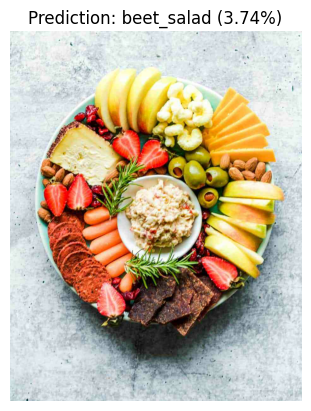


--- Prediction Results ---
{'Predicted Food': 'beet_salad', 'Confidence': '3.74%', 'Estimated Calories': 32.0, 'Weight Assumption (g)': 64}


In [30]:


def mock_calorie_lookup(food_name):
    """Returns a placeholder calorie value per 100g based on food type complexity."""
    if 'cake' in food_name or 'pizza' in food_name or 'pie' in food_name:
        return 300
    elif 'salad' in food_name or 'apple' in food_name or 'broccoli' in food_name:
        return 50
    else:
        return 150


class_names = [f"class_{i}" for i in range(101)]


class_names = [
    "apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare",
    "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito",
    "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake",
    "ceviche", "cheesecake", "cheese_plate", "chicken_curry", "chicken_quesadilla",
    "chicken_wings", "chocolate_cake", "chocolate_mousse", "churros", "clam_chowder",
    "club_sandwich", "crab_cakes", "creme_brulee", "croque_madame", "cup_cakes",
    "deviled_eggs", "donuts", "dumplings", "edamame", "eggs_benedict", "escargots",
    "falafel", "filet_mignon", "fish_and_chips", "foie_gras", "french_fries",
    "french_onion_soup", "french_toast", "fried_calamari", "fried_rice", "frozen_yogurt",
    "garlic_bread", "gnocchi", "greek_salad", "grilled_cheese_sandwich", "grilled_salmon",
    "guacamole", "gyoza", "hamburger", "hot_and_sour_soup", "hot_dog", "huevos_rancheros",
    "hummus", "ice_cream", "lasagna", "lobster_bisque", "lobster_roll_sandwich",
    "macaroni_and_cheese", "macarons", "miso_soup", "mussels", "nachos", "omelette",
    "onion_rings", "oysters", "pad_thai", "paella", "pancakes", "panna_cotta",
    "peking_duck", "pho", "pizza", "pork_chop", "poutine", "prime_rib", "pulled_pork_sandwich",
    "ramen", "ravioli", "red_velvet_cake", "risotto", "samosa", "sashimi", "scallops",
    "seaweed_salad", "shrimp_and_grits", "spaghetti_bolognese", "spaghetti_carbonara",
    "spring_rolls", "steak", "strawberry_shortcake", "sushi", "tacos", "takoyaki",
    "tiramisu", "tuna_tartare", "waffles"
]



calorie_map = {name: mock_calorie_lookup(name) for name in class_names}
print("\n--- Calorie Lookup Map Created (Using Placeholder Mock Data) ---")


def predict_and_estimate(image_path, model, class_names, calorie_map, estimated_weight_g=100):
    """
    Predicts the food item from an image file and estimates its calorie content.
    """
    IMAGE_SIZE = 224

    try:
        img_raw = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        print("Please upload a valid JPG image to Colab.")
        return None

    img_tensor = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img_tensor = tf.cast(img_tensor, tf.float32) / 255.0
    img_array = np.expand_dims(img_tensor, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    if predicted_index < len(class_names):
        predicted_food_name = class_names[predicted_index]
    else:
        predicted_food_name = f"Unknown_Class_{predicted_index}"
    base_calories = calorie_map.get(predicted_food_name.lower(), 150)
    total_calories = (base_calories / 100.0) * estimated_weight_g

    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Prediction: {predicted_food_name} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    return {
        "Predicted Food": predicted_food_name,
        "Confidence": f"{confidence*100:.2f}%",
        "Estimated Calories": round(total_calories, 2),
        "Weight Assumption (g)": estimated_weight_g
    }



uploaded_image_path = "//content/food1.jpg"
estimated_weight = 64

print("\n--- Testing Prediction and Calorie Estimation ---")


model = tf.keras.models.load_model("/content/food_recognition_model_tfds.h5")
print("Model Loaded Successfully!")
print("Model output shape:", model.output_shape)

# Predict
results = predict_and_estimate(uploaded_image_path, model, class_names, calorie_map, estimated_weight)

print("\n--- Prediction Results ---")
print(results)
